In [35]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from audiffuse import Audiffuse
from es_dataset import EpidemicSoundDataset
from lightning.pytorch.utilities.deepspeed import convert_zero_checkpoint_to_fp32_state_dict

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from diffusers import DDIMScheduler

In [36]:
def save_images(images, img_idx, save_dir):
    """
    Saves the given images in a directory with the image index as the folder name.
    """
    folder_name = f"{img_idx}"
    folder_path = os.path.join(save_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    for i, img in enumerate(images):
        img_path = os.path.join(folder_path, f"{i}.png")
        plt.imsave(img_path, img.transpose(1, 2, 0).clip(0, 1))


In [50]:
try:
    os.remove('/scratch/korte/audiffuse/full_model.ckpt')
except:
    print('No file to remove')
# ckpt_path = '/scratch/korte/audiffuse/lightning_logs/version_14/checkpoints/diffuser-epoch=454-val/loss=0.03.ckpt/'
ckpt_path = '/scratch/korte/audiffuse/lightning_logs/version_13/checkpoints/last.ckpt/'
convert_zero_checkpoint_to_fp32_state_dict(ckpt_path, '/scratch/korte/audiffuse/full_model.ckpt')

Processing zero checkpoint '/scratch/korte/audiffuse/lightning_logs/version_13/checkpoints/last.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 8
Parsing checkpoint created by deepspeed==0.10.2
Reconstructed Frozen fp32 state dict with 446 params 114993646 elements
Reconstructed fp32 state dict with 686 params 859520964 elements
Saving fp32 state dict to /scratch/korte/audiffuse/full_model.ckpt


In [3]:
ckpt = torch.load('/scratch/korte/audiffuse/full_model_frozen.ckpt')

In [7]:
ckpt.keys()
# ckpt['frozen_param_fragments'].keys()

dict_keys(['buffer_names', 'param_shapes', 'frozen_param_shapes', 'shared_params', 'frozen_param_fragments', 'data_sampler', 'random_ltd', 'sparse_tensor_module_names', 'global_samples', 'ds_config', 'ds_version', 'epoch', 'global_step', 'pytorch-lightning_version', 'loops', 'callbacks', 'lr_schedulers', 'hparams_name', 'hyper_parameters', 'state_dict'])

In [ ]:
for key in ckpt['frozen_param_fragments'].keys():
    if 'cond_stage_model' in key:
        print(key)

In [51]:
model = Audiffuse.load_from_checkpoint('/scratch/korte/audiffuse/full_model.ckpt', strict=False)
model = model.to('cuda')

In [4]:
dataset = EpidemicSoundDataset('/fastscratch/korte/es-dataset/')

In [66]:
img = dataset[3283]['album_art']
song = dataset[3283]['audio']

for key in song:
    if isinstance(song[key], torch.Tensor):
        song[key] = song[key].unsqueeze(0).to(model.device)

In [36]:
print(song['waveform'].shape)

torch.Size([1, 480000])


In [37]:
t = 999

with torch.no_grad():
    model.diffuser_model.train()
    model.noise_scheduler.set_timesteps(1000)

    encoded_audio = model.encode_audio(song)

    # latent_image = model.encode_images(img.unsqueeze(0).to(model.device))
    # noise = torch.randn((1, 4, 64, 64)).to(model.device)
    # noisy_latents = model.noise_scheduler.add_noise(latent_image, noise, torch.tensor(t))
    # latents = noisy_latents.clone()

    
    latents = torch.randn((1, 4, 64, 64)).to(model.device)

    for t in tqdm(model.noise_scheduler.timesteps[-t:]):
        input_latents = latents
        input_latents = model.noise_scheduler.scale_model_input(latents, t)
        pred_noise = model(input_latents, t, encoded_audio).sample
        latents = model.noise_scheduler.step(pred_noise, t, latents, return_dict=False)[0]

    images = model.decode_latents(latents)

  0%|          | 0/999 [00:00<?, ?it/s]

In [38]:
latents.max(), latents.min(), latents.mean(), latents.std()

(tensor(3.7550, device='cuda:0'),
 tensor(-3.1060, device='cuda:0'),
 tensor(-0.1953, device='cuda:0'),
 tensor(1.7507, device='cuda:0'))

In [39]:
latent_image.max(), latent_image.min(), latent_image.mean(), latent_image.std()

(tensor(2.9256, device='cuda:0'),
 tensor(-3.4932, device='cuda:0'),
 tensor(0.1109, device='cuda:0'),
 tensor(1.1800, device='cuda:0'))

In [40]:
noisy_latents.max(), noisy_latents.min(), noisy_latents.mean(), noisy_latents.std()

(0.6198329, 0.2286455, 0.44913718, 0.047796424)

In [41]:
images.min(), images.max(), images.mean(), images.std()

(tensor(-1.7423, device='cuda:0'),
 tensor(1.0390, device='cuda:0'),
 tensor(-0.6666, device='cuda:0'),
 tensor(0.5099, device='cuda:0'))

In [ ]:
img = img.cpu().numpy() * 0.5 + 0.5
images = images[0].cpu().numpy() * 0.5 + 0.5
noisy_latents = model.first_stage_model.decode(noisy_latents).sample[0].cpu().numpy() * 0.5 + 0.5

In [64]:
images.min(), images.max()

(-0.11858976, 1.0427701)

In [53]:
idx = 19316#torch.randint(0, len(dataset), (1,)).item()
print(idx)
# 6821 11139 811

img = dataset[idx]['album_art']
song = dataset[idx]['audio']

for key in song:
    if isinstance(song[key], torch.Tensor):
        song[key] = song[key].unsqueeze(0).to(model.device)

images = model.gen_images(song, num_images=3, num_inference_steps=100).cpu().numpy()
if type(img) == torch.Tensor:
    img = img.cpu().numpy() * 0.5 + 0.5

19316


  0%|          | 0/100 [00:00<?, ?it/s]

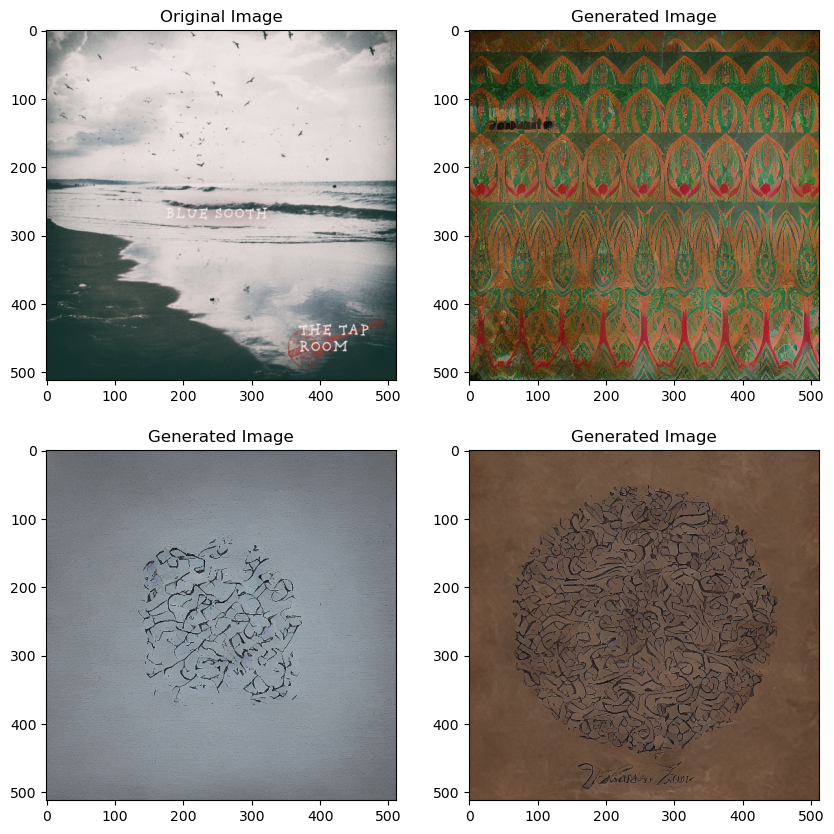

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].imshow(img.transpose(1, 2, 0).clip(0, 1))
axs[0][0].set_title('Original Image')
axs[0][1].imshow(images[0].transpose(1, 2, 0).clip(0, 1))
axs[0][1].set_title('Generated Image')
axs[1][0].imshow(images[1].transpose(1, 2, 0).clip(0, 1))
axs[1][0].set_title('Generated Image')
axs[1][1].imshow(images[2].transpose(1, 2, 0).clip(0, 1))
axs[1][1].set_title('Generated Image')
# axs[2].imshow(noisy_latents.transpose(1, 2, 0).clip(0, 1))
# axs[2].set_title('Noisy Latent')
plt.show()

In [48]:
save_images(np.concatenate([np.expand_dims(img, axis=0), images], axis=0), idx, 'saved_images/')